In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.spatial.distance import cdist
import seaborn as sns
from tqdm import tqdm
from sklearn import linear_model
import random

In [3]:
def find_interphase_sigmoid(Mod,p0):
    upper_index = []
    lower_index = []
    upper_interphase = np.zeros(Mod.shape)
    lower_interphase=np.zeros(Mod.shape)
    x_data = np.arange(int(Mod.shape[0]))
    x_index = np.arange(0, int(Mod.shape[1]))
    def uppersigmoid(x,a1,k1,x01,a2):

        sigmoid1 = a1 / (1 + np.exp(-k1 * (x - x01))) +a2
        return sigmoid1
       
    def doublesigmoid(x,a1,k1,x01,a2,k2,x02,a3):

        sigmoid1 = a1 / (1 + np.exp(-k1 * (x - x01))) +a2 + a3 / (1 + np.exp(-k2 * (x - x02)))
        return sigmoid1

    fig=plt.figure(figsize=(8,6))
    ax=fig.add_subplot(111)

    for i in tqdm(x_index):
        y_data = Mod[:, i]
        valid = np.nonzero(~(np.isnan(y_data) |
                                np.isinf(y_data)))
        x_data_=x_data[valid]
        y_data_=y_data[valid]
        y_data_normalized=(y_data_-y_data_.min())/(y_data_.max()-y_data_.min())


        try:


            popt_min, pcov = sp.optimize.curve_fit(doublesigmoid, x_data_, y_data_normalized, method='dogbox',maxfev=10000,absolute_sigma=False,p0=p0)
            upper_interphase[int(popt_min[2]),i]=1
            upper_index.append([popt_min[2],i])
            lower_interphase[int(popt_min[5]),i]=1
            lower_index.append([popt_min[5],i])
            ax.scatter(x_data_,y_data_normalized,s=1)
            ax.plot(x_data_,doublesigmoid(x_data_,*popt_min))
        except RuntimeError:
            pass
        except IndexError:
            pass 
    plt.show()
    upper_index=np.array(upper_index)
    lower_index=np.array(lower_index)
    return upper_interphase,lower_interphase,upper_index,lower_index

In [4]:
def interphase_mat2coord(interphase_matrix):
    return np.vstack(np.where(interphase_matrix==1)).T

In [5]:
def build_distant_matrix_euclid(interphase_index):
    """
    Calculate the distance from the nearest interphase for all points.
    input : interphase_matrix
    output : distant_matrix
    """
    coordinate=np.stack(np.meshgrid(np.arange(0,128),np.arange(0,128)), -1).reshape(-1, 2)

    # Calculate the distance between each point in A and B
    distances = cdist(coordinate, interphase_index)

    # Find the index of the closest point in interphase for each coordinate
    closest_indices = np.argmin(distances, axis=1)

    # Calculate the closest distances
    distant_matrix = np.array(distances[np.arange(len(coordinate)), closest_indices]).reshape((128,128)).T
    for i in interphase_index:
        crit_x = i[0]
        if crit_x != None:
            for j in np.arange(128):
                if j >= crit_x:
                    distant_matrix[j, i[1]] = -distant_matrix[j, i[1]]
                else:
                    pass
        else:
            distant_matrix[:, i[1]] = None
    return distant_matrix

In [6]:
def calc_thickness(interphase_index1,interphase_index2,length_per_cell):

    d_all=np.empty((1000))

    for i in tqdm(range(1000)):
        ind1 = np.random.choice(np.arange(interphase_index1.shape[0]), interphase_index1.shape[0])
        ind2 = np.random.choice(np.arange(interphase_index2.shape[0]), interphase_index2.shape[0])
        xy1=interphase_index1[ind1]
        xy2 = interphase_index2[ind2]
        ransac1 = linear_model.RANSACRegressor(estimator=linear_model.LinearRegression())
        ransac1.fit(xy1[:,1].reshape(-1, 1), xy1[:,0].reshape(-1, 1))
        a1=(ransac1.predict([[1]])-ransac1.predict([[0]]))[0,0]
        b1=ransac1.predict([[0]])[0,0]

        ransac2 = linear_model.RANSACRegressor(estimator=linear_model.LinearRegression())
        ransac2.fit(xy2[:,1].reshape(-1, 1), xy2[:,0].reshape(-1, 1))
        a2=(ransac2.predict([[1]])-ransac2.predict([[0]]))[0,0]
        b2=ransac2.predict([[0]])[0,0]

        d=(np.abs(b1-b2)/np.sqrt(1+((a1+a2)**2/4)))*length_per_cell
        d_all[i]=d
        i+=1

    return d_all


In [7]:
with open(r"5wt.txt","r") as f:
    txt=f.read()

In [8]:
txt

'66.822021484375\t66.86525726318359\t67.45828247070312\t68.08077239990234\t66.81470489501953\t68.01792144775391\t67.43577575683594\t68.03582000732422\t67.28250122070312\t68.04981231689453\t67.12498474121094\t67.40371704101562\t68.006103515625\t67.26007843017578\t66.807861328125\t67.24210357666016\t67.69976806640625\t68.86249542236328\t68.67995452880859\t66.59307098388672\t66.48093414306641\t66.67905426025391\t67.16935729980469\t66.59983062744141\t66.70063781738281\t66.65023040771484\t65.81990814208984\t64.45676422119141\t63.03090286254883\t61.77198028564453\t61.30487060546875\t61.44649124145508\t61.26203918457031\t60.29470825195312\t60.36465835571289\t58.69692611694336\t57.61477279663086\t56.47644424438477\t56.18352508544922\t56.56697082519531\t56.43693923950195\t56.09393692016602\t56.35342407226562\t56.13505172729492\t56.03668975830078\t57.13815307617188\t57.92816162109375\t59.29971313476562\t59.31351089477539\t61.41698455810547\t61.1469612121582\t60.97392654418945\t60.92431640625\t61

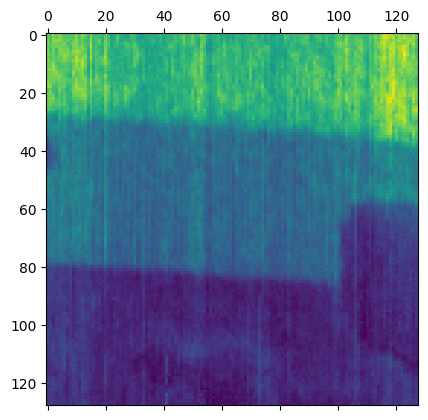

In [12]:



real_dimension=[454,454]
lines=(128,128)
# real_dimension=[5040,3740]
# lines=(128,-1)

length_per_cell=real_dimension[0]/lines[0]

with open(r"5wt.txt","r") as f:
    txt=f.read()
val=np.rot90(np.array([float(x) for x in txt.replace("\n","\t").split("\t")]).reshape(lines))

plt.matshow(val[::-1,:])
# upper,lower,uind,lind=find_interphase_sigmoid(val[::-1,:], [1,1,50,1,1,100,1])
# fig=plt.figure(figsize=(8,6))
# ax1=fig.add_subplot(121)
# ax2=fig.add_subplot(122)
# ax2.matshow(upper)
# ax1.matshow(lower)


# # upper_coordinate=interphase_mat2coord(upper)
# # lower_coordinate=interphase_mat2coord(lower)
# d=calc_thickness(uind,lind,length_per_cell)
# print(np.mean(np.array(d)),np.std(np.array(d)))


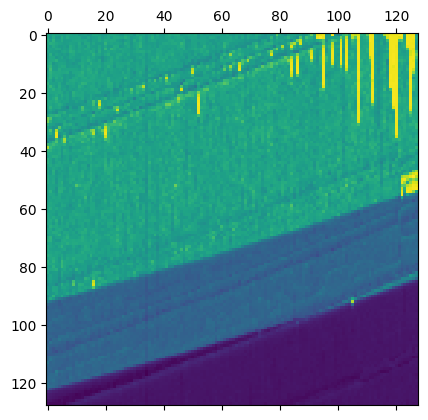

In [13]:
real_dimension=[5040,5040]
lines=(128,-1)

length_per_cell=real_dimension[0]/lines[0]

with open(r"20wt","r") as f:
    txt=f.read()
val=np.rot90(np.array([float(x) for x in txt.replace("\n","\t").split("\t")]).reshape(lines))

plt.matshow(val)
# upper,lower,uind,lind=find_interphase_sigmoid(val[:,0:100],[1,1,42,1,1,70,1])
# fig=plt.figure(figsize=(8,6))
# ax1=fig.add_subplot(121)
# ax2=fig.add_subplot(122)
# ax1.matshow(lower)
# ax2.matshow(upper)

# d=calc_thickness(uind,lind,length_per_cell)
# print(np.mean(np.array(d)),np.std(np.array(d)))

  0%|          | 0/128 [00:00<?, ?it/s]

  9%|▉         | 12/128 [00:00<00:01, 102.73it/s]C:\Users\Io Saito\AppData\Local\Temp\ipykernel_28788\1965697525.py:15: RuntimeWarning: overflow encountered in exp
  sigmoid1 = a1 / (1 + np.exp(-k1 * (x - x01))) +a2 + a3 / (1 + np.exp(-k2 * (x - x02)))
100%|██████████| 128/128 [00:01<00:00, 111.69it/s]


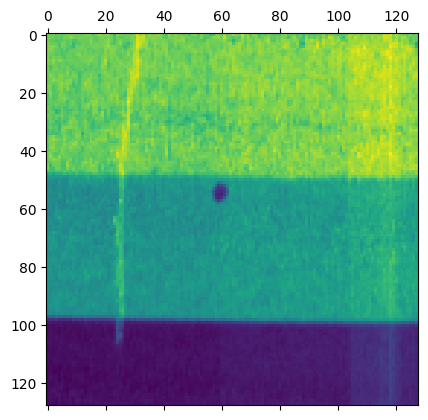

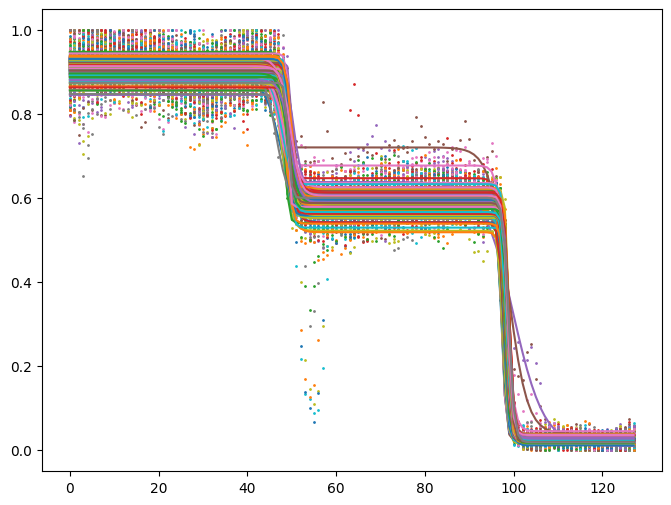

100%|██████████| 1000/1000 [00:08<00:00, 112.34it/s]


484.599127975928 2.1069556087955017


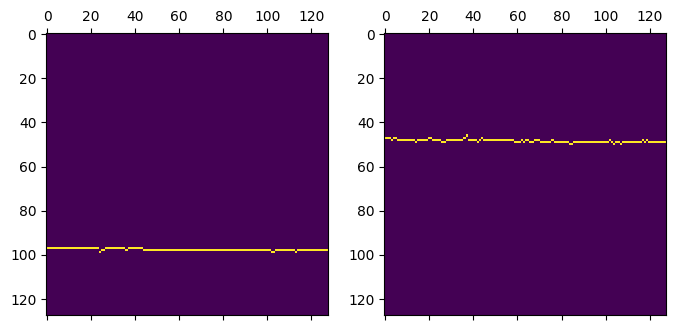

In [34]:
real_dimension=[1260,1260]
lines=(128,128)

length_per_cell=real_dimension[0]/lines[0]

with open(r"10wt_cropped","r") as f:
    txt=f.read()
val=np.rot90(np.array([float(x) for x in txt.replace("\n","\t").split("\t")]).reshape(lines))

plt.matshow(val)

upper,lower,uind,lind=find_interphase_sigmoid(val,[1,1,50,1,1,100,1])
fig=plt.figure(figsize=(8,6))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
ax1.matshow(lower)
ax2.matshow(upper)

d=calc_thickness(uind,lind,length_per_cell)
print(np.mean(np.array(d)),np.std(np.array(d)))

100%|██████████| 75/75 [00:01<00:00, 70.52it/s]


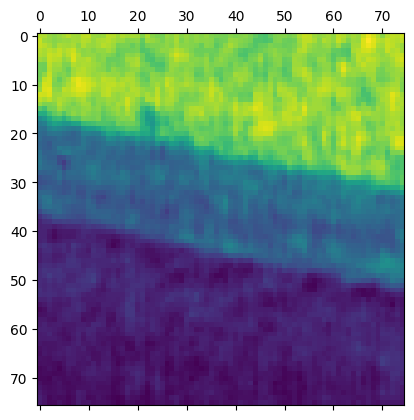

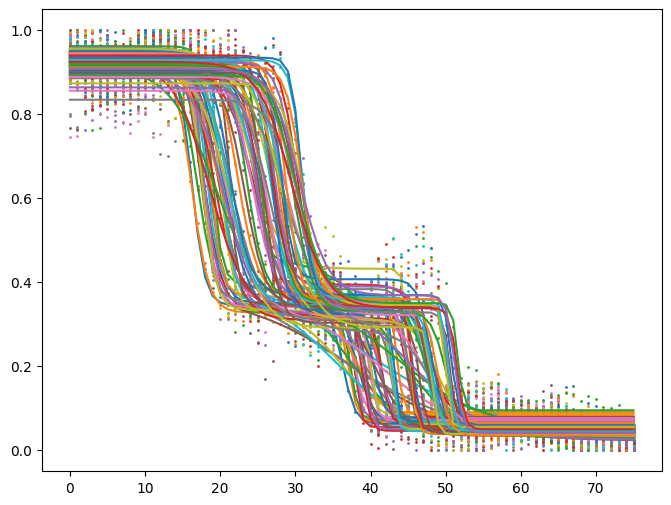

100%|██████████| 1000/1000 [00:04<00:00, 217.41it/s]


88.9645538925518 1.4529771951996513


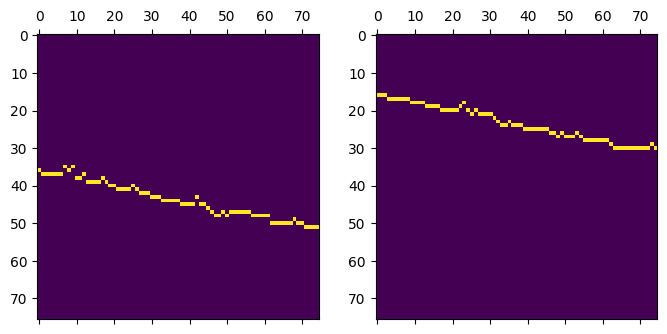

In [35]:
real_dimension=[341,337]
lines=(75,-1)

length_per_cell=real_dimension[0]/lines[0]

with open(r"2.5wt_cropped","r") as f:
    txt=f.read()
val=np.rot90(np.array([float(x) for x in txt.replace("\n","\t").split("\t")]).reshape(lines))

plt.matshow(val)
upper,lower,uind,lind=find_interphase_sigmoid(val,[1,1,20,1,1,50,1])
fig=plt.figure(figsize=(8,6))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
ax1.matshow(lower)
ax2.matshow(upper)

d=calc_thickness(uind,lind,length_per_cell)
print(np.mean(np.array(d)),np.std(np.array(d)))

ValueError: x and y must be the same size

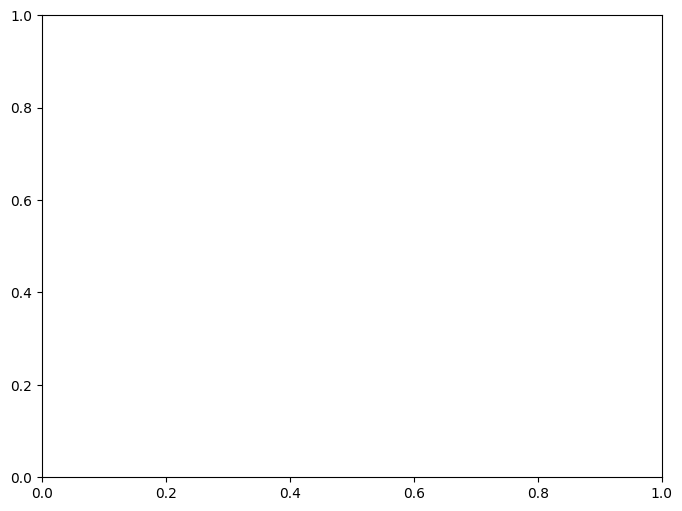

In [ ]:
label=["low force","high force"]
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
for i,j in enumerate(dist):
    ax.scatter(j,mod[i],s=1,label=label[i])
ax.legend(loc="upper right")
# ax.set_xlim(0,2802)

In [104]:
#WTF function

T=[-29.995,-24.995,-20,-15.004,-10,-5,0.151,5.025,10.001,14.999,19.999,24.998,29.997]
aT=[5.56E+11,1.81E+10,1.02E+09,7585220,122691,5481.09,733.313,173.605,61.5975,18.4272,6.53906,2.81803,1]
log_a=np.log10(aT)

def WLF(x,c1,c2):
    return -c1*(x-25)/(c2+(x-25))

popt,pcov=sp.optimize.curve_fit(WLF,T,log_a)

In [105]:
popt

array([-4.64497773, -0.02062763])

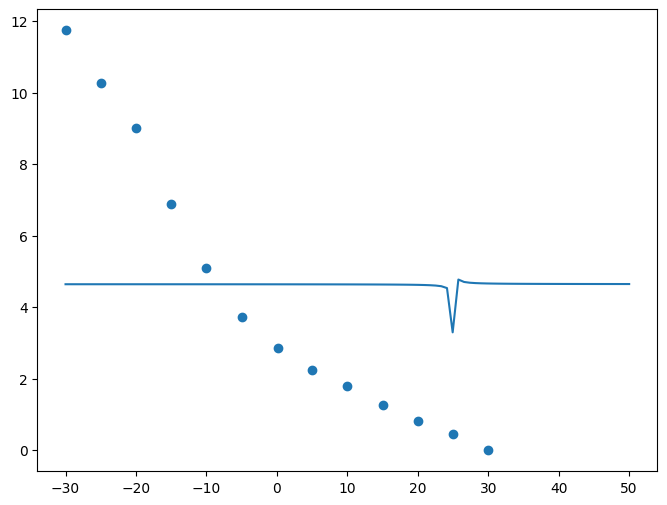

In [107]:
x_=np.linspace(-30,50,100)
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.scatter(T,log_a)
ax.plot(x_,WLF(x_,*popt))

In [102]:
a=10**WLF(46.9,*popt)

In [103]:
a

1.086884231249394e-19